# Mini Spark Broker: using official LSST alerts

author: **Julien Peloton** [@JulienPeloton](https://github.com/JulienPeloton)  
Last Verifed to Run: 2019-02-06  

The purpose of this notebook is to connect the broker to the stream created by the LSST alert system _with LSST alerts_.

**Useful Links:**

* https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html
* https://github.com/lsst-dm/alert_stream

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import window
from pyspark.sql import Row

import io
import time
import struct

import fastavro
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from lsst.msb import avroUtils
from lsst.msb.filtering import make_dataframe_from_alerts

## Step 0: Running the LSST alert system with LSST alerts

In order to play with this notebook, you need to create the stream of alerts from LSST. This is very similar to the ZTF one we played with so far, with few modifications though. The best, in order to avoid any conflicting situation is to grab the official LSST alert stream repo and create the stream from it. Here are the steps to follow:

```bash
# Go to where you put user lib
# Clone the repo (make sure you have git-lfs to pull the data)
git clone https://github.com/lsst-dm/alert_stream.git

# Checkout current working branch
cd alert_stream && git checkout tickets/DM-17549

# Launch Zookeeper & Kafka servers
# Network name will be alert_stream_default
docker-compose up -d

# Build the container
docker build -t "alert_stream" .

# Launch the stream
docker run -it --rm \
    --network=alert_stream_default \
    -v $PWD/data:/home/alert_stream/data:ro \
    alert_stream python bin/sendAlertStream.py \
    kafka:9092 lsst-stream
```

From this point, a stream with 4 bursts of 10,000 alerts each will be created. Then launch the bootcamp with the `alert_stream_default` network:

```bash
###################################
# Mini Spark Broker with LSST alerts
###################################

# Kafka dependencies
KFKSTREAM=org.apache.spark:spark-streaming-kafka-0-10-assembly_2.10:2.2.0
KFKSQL=org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.0

# Network used by the LSST alert system
NETWORK=alert_stream_default

# Run jupyter through the Docker
docker run -it --rm  \
	-v $PWD:/home/jovyan/work:rw -p 8888:8888 -p 400:4040 \
    --network=${NETWORK} -P msb \
	/usr/local/spark/bin/pyspark --packages ${KFKSTREAM},${KFKSQL}
```

Done. You can play this notebook with LSST alerts!

## Step 1: Connecting to the stream with Apache Spark

Once the stream is produced, let's initialise the Spark context:

In [2]:
# Grab the running Spark Session, 
# otherwise create it.
spark = SparkSession \
    .builder \
    .appName("firstConnection") \
    .getOrCreate()

Let's initialise a DataFrame that will read the stream from Kafka. Note that `kafka.bootstrap.servers` and `subscribe` must correspond to the arguments used for the LSST alert system (see above). At this point, we just create a Kafka Source for Streaming Queries - nothing really happens:

In [3]:
# Create a DF from the incoming stream from Kafka
# Note that <kafka.bootstrap.servers> and <subscribe>
# must correspond to arguments of the LSST alert system.
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9092") \
  .option("subscribe", "lsst-stream") \
  .option("startingOffsets", "earliest") \
  .load()

df.isStreaming

True

As you can see, `df` is a streaming Dataframe. You can start streaming computation, by defining the sink and starting it. 
<!-- In our case, we want to interactively query the counts (same queries as above), so we will set the complete set of 1 hour counts to be in a in-memory table (note that this for testing purpose only in Spark 2.0). -->

## Step 2: First interaction with the stream

Let's see first if we can receive correctly alert packets. For this, we define a query to the stream that will just group alerts by publication date (window of 5 seconds):

In [4]:
# We group data by partitions, 
# and count the number of alerts per partition
# every 5 seconds.
streamingCountsDF = (
  df.groupBy(
      "partition", 
      window("timestamp", "5 seconds"))
    .count()
)

In [5]:
# keep the size of shuffles small
spark.conf.set("spark.sql.shuffle.partitions", "2")  

# Trigger the streaming computation, 
# by defining the sink (memory here) and starting it
countQuery = streamingCountsDF \
    .writeStream \
    .queryName("qcount")\
    .format("memory")\
    .outputMode("complete") \
    .start()

`qcount` is a handle to the streaming query that is running in the background. This query is continuously picking up alerts and updating the counts. Let's give a bit of time for the stream to update. 

In [6]:
time.sleep(10)

You can easily access information about the progress in real-time:

In [7]:
countQuery.recentProgress

[{'id': '641ee262-98d4-49aa-8682-84f1034ead42',
  'runId': '9ea32363-31b1-450c-bc7d-d383d4a61571',
  'name': 'qcount',
  'timestamp': '2019-02-11T15:00:41.350Z',
  'batchId': 0,
  'numInputRows': 40000,
  'processedRowsPerSecond': 4535.661639641682,
  'durationMs': {'addBatch': 4568,
   'getBatch': 8,
   'getEndOffset': 0,
   'queryPlanning': 389,
   'setOffsetRange': 3732,
   'triggerExecution': 8818,
   'walCommit': 59},
  'stateOperators': [{'numRowsTotal': 38,
    'numRowsUpdated': 38,
    'memoryUsedBytes': 8605,
    'customMetrics': {'loadedMapCacheHitCount': 0,
     'loadedMapCacheMissCount': 0,
     'stateOnCurrentVersionSizeBytes': 8317}}],
  'sources': [{'description': 'KafkaV2[Subscribe[lsst-stream]]',
    'startOffset': None,
    'endOffset': {'lsst-stream': {'0': 40000}},
    'numInputRows': 40000,
    'processedRowsPerSecond': 4535.661639641682}],
  'sink': {'description': 'MemorySink'}},
 {'id': '641ee262-98d4-49aa-8682-84f1034ead42',
  'runId': '9ea32363-31b1-450c-bc7d-

You can also use sql operations on the named in-memory query tables to create a classic DataFrame from the sink:

In [8]:
# Construct a DataFrame with time & number of alerts published by 
# window of 5 seconds
df_alert_count = spark.sql(
    """
    select 
        window.start as starting_utc_time, 
        window.end as ending_utc_time, 
        count as alerts_published 
    from 
        qcount 
    order by 
        ending_utc_time
    """
)

# Show the first rows of the DataFrame
df_alert_count.show()

# Count the number of alerts published so far
nalerts = df_alert_count.select("alerts_published").rdd.map(lambda x: x[0]).sum()
print("{} alerts published so far from the stream".format(nalerts))

+-------------------+-------------------+----------------+
|  starting_utc_time|    ending_utc_time|alerts_published|
+-------------------+-------------------+----------------+
|2019-02-11 12:18:20|2019-02-11 12:18:25|             957|
|2019-02-11 12:18:25|2019-02-11 12:18:30|            1140|
|2019-02-11 12:18:30|2019-02-11 12:18:35|            1128|
|2019-02-11 12:18:35|2019-02-11 12:18:40|            1012|
|2019-02-11 12:18:40|2019-02-11 12:18:45|             891|
|2019-02-11 12:18:45|2019-02-11 12:18:50|             928|
|2019-02-11 12:18:50|2019-02-11 12:18:55|            1104|
|2019-02-11 12:18:55|2019-02-11 12:19:00|            1020|
|2019-02-11 12:19:00|2019-02-11 12:19:05|            1335|
|2019-02-11 12:19:05|2019-02-11 12:19:10|             485|
|2019-02-11 12:19:40|2019-02-11 12:19:45|             908|
|2019-02-11 12:19:45|2019-02-11 12:19:50|            1235|
|2019-02-11 12:19:50|2019-02-11 12:19:55|            1214|
|2019-02-11 12:19:55|2019-02-11 12:20:00|            109

Note the columns `starting_time` and `ending_time` here correspond to the UTC times at which the alert has been published in Kafka (not the time at which you grab the alert).

Below I plot the values collected after 3 full bursts of alerts sent at few hours interval:

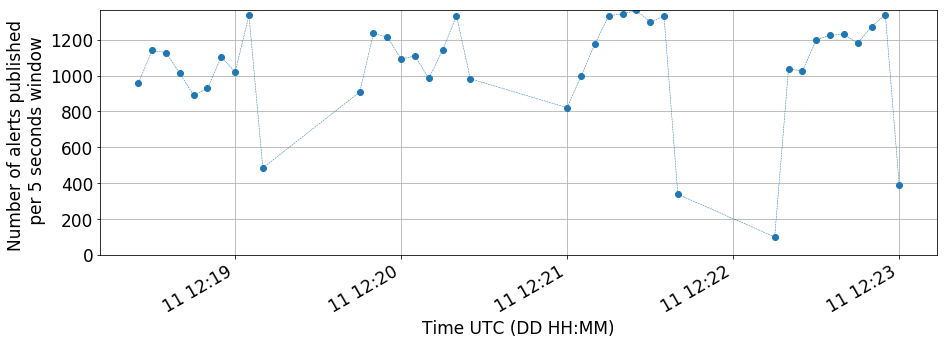

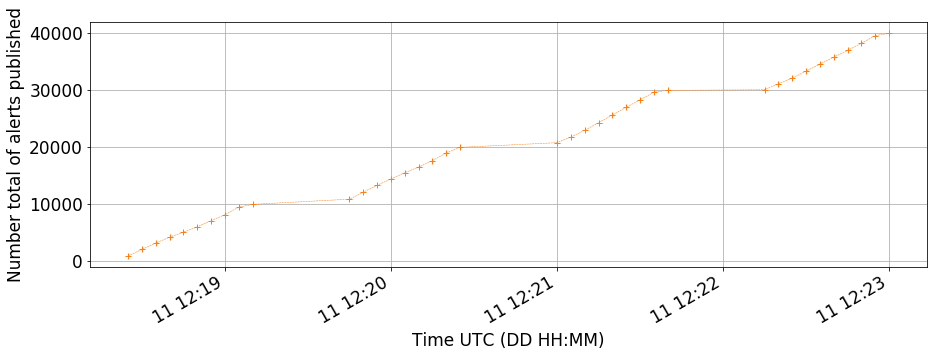

In [9]:
matplotlib.rcParams.update({'font.size': 17})

# Go to Pandas world for plotting
pandas_df = df_alert_count.toPandas()

fig = plt.figure(figsize=(15, 5))
plt.plot(
    pandas_df["ending_utc_time"], 
    pandas_df["alerts_published"], 
    ls="--", lw=0.5, marker="o", color="C0")
plt.grid()

plt.ylim(0, pandas_df["alerts_published"].max() + 1)
plt.xlabel("Time UTC (DD HH:MM)")
plt.ylabel("Number of alerts published \n per 5 seconds window")

plt.gcf().autofmt_xdate()

fig = plt.figure(figsize=(15, 5))
plt.plot(
    pandas_df["ending_utc_time"], 
    np.cumsum(pandas_df["alerts_published"]), 
    ls="--", marker="+", lw=0.5, color="C1")
plt.grid()

plt.xlabel("Time UTC (DD HH:MM)")
plt.ylabel("Number total of alerts published")

plt.gcf().autofmt_xdate()

Note that this corresponds to publication times. If you want to look at Spark performances, you can open the Spark UI and browse logs of jobs: http://localhost:400. In this simple example, Spark consumes all alerts in less than a second.

## Step 4: Digging the alerts

Now it is time to look at the alerts! The alert system encodes the alert in avro binary, so one needs to decode them.
The way to decode the alert is to know its schema. We put a template alert in the folder `schemas` for convenience. Let's create a sink with the whole stream from Kafka, and access the alert through a DataFrame:

In [10]:
rawQuery = df\
    .writeStream \
    .queryName("qraw")\
    .format("memory")\
    .start()

In [11]:
# Give a bit of time for synchronisation
time.sleep(10)

In [12]:
# DataFrame
df_raw = spark.sql("select * from qraw")
df_raw.show(10)

+----+--------------------+-----------+---------+------+--------------------+-------------+
| key|               value|      topic|partition|offset|           timestamp|timestampType|
+----+--------------------+-----------+---------+------+--------------------+-------------+
|null|[00 A2 B9 B1 0F 8...|lsst-stream|        0|     0|2019-02-11 12:18:...|            0|
|null|[00 A2 B9 B1 0F 8...|lsst-stream|        0|     1|2019-02-11 12:18:...|            0|
|null|[00 A2 B9 B1 0F 8...|lsst-stream|        0|     2|2019-02-11 12:18:...|            0|
|null|[00 A2 B9 B1 0F 8...|lsst-stream|        0|     3|2019-02-11 12:18:...|            0|
|null|[00 A2 B9 B1 0F 8...|lsst-stream|        0|     4|2019-02-11 12:18:...|            0|
|null|[00 A2 B9 B1 0F 8...|lsst-stream|        0|     5|2019-02-11 12:18:...|            0|
|null|[00 A2 B9 B1 0F 8...|lsst-stream|        0|     6|2019-02-11 12:18:...|            0|
|null|[00 A2 B9 B1 0F 9...|lsst-stream|        0|     7|2019-02-11 12:18:...|   

We can look closely at the columns of this Dataframe:

In [13]:
df_raw.printSchema()
df_raw.describe().show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------+-----------+---------+------------------+-------------+
|summary|      topic|partition|            offset|timestampType|
+-------+-----------+---------+------------------+-------------+
|  count|      40000|    40000|             40000|        40000|
|   mean|       null|      0.0|           19999.5|          0.0|
| stddev|       null|      0.0|11547.149720457714|          0.0|
|    min|lsst-stream|        0|                 0|            0|
|    max|lsst-stream|        0|             39999|            0|
+-------+-----------+---------+------------------+-------------+



The column of interest for us is `value` which contains the alert data. For the moment, the data is `binary`, so let's decode it. First read the corresponding schema (LSST in this example):

In [15]:
# Read the schema
alert_schema = avroUtils.readSchemaFromAvroFile("../schemas/template_schema_LSST.avro")

# Broadcast the schema to all Spark executors
# (Keep in mind we work in a distributed environment!)
sc.broadcast(alert_schema)

# Look at the available keys
print(alert_schema.keys())

dict_keys(['type', 'name', 'fields'])


Now we have the schema, we can decode the alerts. For technical reason, you need to go to RDD world to use in a meaningful way the decoder:

In [16]:
# RDD: Resilient Distributed Dataset.
# Both Spark DataFrames and RDDs are distributed memory abstractions, fault-tolerant and immutable.
# The main difference is that Dataframes are organized into named columns with defined 
# data types and including the benefits of Spark SQL's execution engine.
# Historically, there were only RDDs. DataFrame came later in Spark.

# LSST alerts are split into 2 parts: the hash & the data
rdd_hash = df_raw.select("value").rdd.map(lambda x: struct.unpack("!I", x[0][1:5])[0])
rdd_alerts = df_raw.select("value").rdd.map(lambda x: avroUtils.decoder(x.value[5:], alert_schema))

And here is one full alert:

In [17]:
alert_hash = rdd_hash.take(1)[0]
alert_data = rdd_alerts.take(1)[0]
print("Hash: {}, \nData: {}".format(alert_hash, alert_data))

Hash: 2730078479, 
Data: {'alertId': 12136218625, 'l1dbId': 314049540, 'diaSource': {'diaSourceId': 321586728962, 'ccdVisitId': 41120011574, 'diaObjectId': 314049540, 'ssObjectId': None, 'parentDiaSourceId': None, 'midPointTai': 59595.3722, 'filterName': 'y', 'ra': 157.8336327870972, 'decl': -76.93761744189929, 'ra_decl_Cov': {'raSigma': 0.0008934108191169798, 'declSigma': 0.00015856779646128416, 'ra_decl_Cov': 0.0008191444212570786}, 'x': 1989.8804931640625, 'y': 2979.4912109375, 'x_y_Cov': {'xSigma': 13.060453414916992, 'ySigma': 15.223045349121094, 'x_y_Cov': 0.0001748482318362221}, 'apFlux': None, 'apFluxErr': None, 'snr': 191.3075408935547, 'psFlux': 0.0022566330153495073, 'psRa': None, 'psDecl': None, 'ps_Cov': None, 'psLnL': None, 'psChi2': None, 'psNdata': None, 'trailFlux': None, 'trailRa': None, 'trailDecl': None, 'trailLength': None, 'trailAngle': None, 'trail_Cov': None, 'trailLnL': None, 'trailChi2': None, 'trailNdata': None, 'dipMeanFlux': None, 'dipFluxDiff': None, 'dipR

One could convert this RDD back to DataFrame, but the schema of the alerts is nested, which can lead to trouble.
Instead, let's see what are the keys we have in the alert:

In [18]:
rdd_alerts.map(lambda x: [ (i, type(j)) for i, j in zip(x.keys(), x.values())]).take(1)

[[('alertId', int),
  ('l1dbId', int),
  ('diaSource', dict),
  ('prv_diaSources', NoneType),
  ('diaObject', dict),
  ('ssObject', NoneType),
  ('diaObjectL2', NoneType),
  ('diaSourcesL2', NoneType),
  ('cutoutDifference', NoneType),
  ('cutoutTemplate', NoneType)]]

### Creating DataFrames

Alerts are nest `dict` that can be transformed into a standalone DataFrame by specifying entries of interest:

In [19]:
colnames = [
    "alertId",
    "diaSource:diaSourceId", "diaObject:diaObjectId",
    "diaSource:ra", "diaSource:ra_decl_Cov:raSigma"]
df_simple = make_dataframe_from_alerts(rdd_alerts, colnames)
df_simple.show(10)

+-----------+---------------------+---------------------+------------------+-----------------------------+
|    alertId|diaSource:diaSourceId|diaObject:diaObjectId|      diaSource:ra|diaSource:ra_decl_Cov:raSigma|
+-----------+---------------------+---------------------+------------------+-----------------------------+
|12136218625|         321586728962|            314049540| 157.8336327870972|         8.934108191169798E-4|
|12136218626|         743854575617|            726420484| 159.7720798268905|         6.372298812493682E-4|
|12136218627|         884127830017|            863406084|159.09503271094886|         9.375657537020743E-4|
|12136218628|         884137267201|            863415300| 160.6709513805466|          6.79594959365204E-5|
|12136218629|    73402464468996098|       71682094208004|153.60855310610563|          9.27475281059742E-4|
|12136218630|    73402471277400066|       71682100856836|153.61986953163785|         5.779027123935521E-4|
|12136218631|    73402474062417922|  

### Writing sample alert

Use this to output on disk one alert (avro format):

In [20]:
from fastavro import writer

with open('template_schema_LSST.avro', 'wb') as out:
    writer(out, alert_schema, [alert_data])